<a href="https://colab.research.google.com/github/slowvak/AI-Deep-Learning-Lab/blob/master/1p19qSeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1
!pip install pandas

import numpy as np
import numpy.ma as ma
import os
import shutil
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, Dense, Dropout, Activation, Flatten, BatchNormalization, Reshape
from keras.engine.topology import Layer

from keras.layers.merge import concatenate, add
from keras.layers.core import Lambda
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import imageio
from natsort import natsorted
import random
import warnings
from scipy.ndimage import rotate
warnings.filterwarnings("ignore")
import pandas as pd
import nibabel as nib

!rm -rf trainimages
!mkdir trainimages
!rm -rf trainmasks
!mkdir trainmasks

!rm -rf validationimages
!mkdir validationimages
!rm -rf validationmasks
!mkdir validationmasks

!rm -rf testimages
!mkdir testimages
!rm -rf testmasks
!mkdir testmasks

print("Tensorflow version: " + str(tf.__version__))


Using TensorFlow backend.


Tensorflow version: 1.15.0


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Mar  1 17:44:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:

# get the csv file describing images
#!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1pazXvT4N9-T4OAxcuUiuCd3AUmDaAAxF' -O ./data.csv
#DATA_FILE = "./data.csv"
#IMAGE_DIR = './Nifti'
# then get the images
#!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1V4zAE19E1kLUK0Z0YIWNpMq0K8lOARtu' -O ./images.zip
#!unzip -q -o "./images.zip"


In [3]:
from google.colab import drive
drive.mount('/content/drive')

DATA_FILE = '/content/drive/My Drive/LGG-1p19q/TCIA_LGG_cases_info.csv'
IMAGE_DIR = '/content/drive/My Drive/LGG-1p19q/Nifti/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
# read and process the csv file to find tumor and annotation slices

df = pd.read_csv(DATA_FILE)
print (df)


    Filename 1p19q  Grade  ... TopOfTrace  Unnamed: 8  Unnamed: 9
0    LGG-104   d/d      3  ...         47         NaN         NaN
1    LGG-203   n/n      3  ...         44         NaN         NaN
2    LGG-210   n/n      2  ...         12         NaN         NaN
3    LGG-216   d/d      2  ...         35         NaN         NaN
4    LGG-218   d/d      2  ...         40         NaN         NaN
..       ...   ...    ...  ...        ...         ...         ...
153  LGG-651   d/d      2  ...         39         0.0         NaN
154  LGG-658   d/d      3  ...         51         0.0         NaN
155  LGG-659   d/d      2  ...         48         0.0         NaN
156  LGG-660   d/d      2  ...         32         0.0         NaN
157  LGG-766   n/n      2  ...         49         0.0         NaN

[158 rows x 10 columns]


In [0]:
DIM = 256

def load_nifti(fname):
    # print (fname)
    nifti = nib.load(fname)
    image = nifti.get_fdata()
    dims = np.shape(image)
    xd = dims[0]
    yd = dims[1]
    zd = dims[2]
    if xd > DIM or yd > DIM:  # these are all
        new_image = np.zeros(shape=(DIM, DIM, zd), dtype = np.float64)
        print ("Resizing " + str(fname) + " from " + str(xd) + " x " + str(yd))
        for z in range (0, zd):
            for W in range(DIM):
                for H in range(DIM):
                    new_image[H][W][z] = image[2*H][2*W][z]
        xd = yd = DIM
        try:
            image = new_image
#            newfname = fname.replace (".nii.gz", "256.nii.gz")
#            nifti.header.set_data_shape([xd, yd, zd])
#            nib.save(nib.Nifti1Image(Seg, nifti.affine, nifti.header), newfname)
        except:
            pass
    if (image.max() > 10): # only normalize images, not masks
        image.reshape(xd*yd*zd)
        image = image - np.min(image)
        image = (np.maximum(image, 30) / image.max()) * 255.0
    image.reshape(DIM, DIM, zd)
    dims = np.shape(image)
    if (dims[0] != DIM):
        print ("wrong order")
    return image, nifti

In [6]:
Images = []
Seg_images = []
import time

#studies with 512 matrix: 310, 326, 387, 515
not_seg = 0

for ind in df.index: 
    if 'LGG' in str(df['Filename'][ind]):
        BottomOfTumor = int(df['BottomOfTumor'][ind])
        TopOfTumor = int(df['TopOfTumor'][ind])
        BottomOfTrace = int(df['BottomOfTrace'][ind])
        TopOfTrace = int(df['TopOfTrace'][ind])
        Dir = os.path.join (IMAGE_DIR, df['Filename'][ind])
        Seg_file = os.path.join (Dir, df['Filename'][ind] + '-Segmentation.nii.gz')
        inf = os.path.getmtime(Seg_file)
        print (str(Seg_file) + " -- " + time.ctime(inf))
        if BottomOfTumor == BottomOfTrace and TopOfTumor == TopOfTrace:
            Dir = os.path.join (IMAGE_DIR, df['Filename'][ind])
            T1_file = os.path.join (Dir, df['Filename'][ind] + '_T1.nii.gz')
            if not os.path.exists(T1_file):
                T1_file = os.path.join (Dir, df['Filename'][ind] + '_T1c.nii.gz')
            T2_file = os.path.join (Dir, df['Filename'][ind] + '_T2.nii.gz')
            Seg_file = os.path.join (Dir, df['Filename'][ind] + '-Segmentation.nii.gz')
            Chromosome_status = str(df['1p19q'][ind])
            Grade = int(df['Grade'][ind])
            Type = str(df['Type'][ind])
    #            print (T1_file + ' size: ' + str(os.path.getsize(T1_file)))
            T1, hdr = load_nifti(T1_file)
            T2, hdr = load_nifti(T2_file)
            Seg, hdr = load_nifti(Seg_file)
#Store the training slices into the arrays
# note the slice number start from 1 in ITK-Snap, so must start/stop at 1 less
# only do slices that are fully traced ****************
            for slc in range (BottomOfTrace-1, TopOfTrace):
                # combine the T1 and T2 images
                image = np.dstack((T1[:,:, slc], T2[:,:, slc]))
                # append them onto prior images
                # add data augmentation using rotation
                #Images.append (img)
                #Seg_images.append (img)
                
                for angle in range (-10, 9, 5):
                    img = rotate(image, angle, reshape=False)
                    Images.append (img)
                # print ("Sg min: " + str(Seg[:,:, slc].min()) + " max: " + str(Seg[:,:, slc].max()) + " count: " + str(Seg[:,:, slc].sum()))
                    img = rotate(Seg[:,:, slc], angle, reshape=False)
                    img = (img > 0.5).astype(np.uint8)
                    Seg_images.append (img)
                # now add various noise
                """
                img = image.copy()
                mean = 0.0
                sigma = 0.1
                for i in range (0, 5):
                    noise = np.random.normal(mean, sigma, img.shape)
                    mask_overflow_upper = img+noise >= 1.0
                    mask_overflow_lower = img+noise < 0
                    noise[mask_overflow_upper] = 0
                    noise[mask_overflow_lower] = 0
                    img += noise
                    Images.append (img)
                    Seg_images.append (Seg[:,:, slc])
                """
                
            print ("Processed " + Dir + " " + str(len(Images)) + " total labeled images.")
        else:
            print (Dir + " is not fully segmented")
            not_seg = not_seg + 1
print (str(not_seg) + " not segmeneted")

/content/drive/My Drive/LGG-1p19q/Nifti/LGG-104/LGG-104-Segmentation.nii.gz -- Sun Feb 23 16:14:39 2020
Processed /content/drive/My Drive/LGG-1p19q/Nifti/LGG-104 64 total labeled images.
/content/drive/My Drive/LGG-1p19q/Nifti/LGG-203/LGG-203-Segmentation.nii.gz -- Sun Feb 23 16:21:38 2020
Processed /content/drive/My Drive/LGG-1p19q/Nifti/LGG-203 160 total labeled images.
/content/drive/My Drive/LGG-1p19q/Nifti/LGG-210/LGG-210-Segmentation.nii.gz -- Sun Feb 23 16:24:20 2020
Processed /content/drive/My Drive/LGG-1p19q/Nifti/LGG-210 180 total labeled images.
/content/drive/My Drive/LGG-1p19q/Nifti/LGG-216/LGG-216-Segmentation.nii.gz -- Sun Feb 23 16:29:34 2020
Processed /content/drive/My Drive/LGG-1p19q/Nifti/LGG-216 232 total labeled images.
/content/drive/My Drive/LGG-1p19q/Nifti/LGG-218/LGG-218-Segmentation.nii.gz -- Sun Feb 23 16:34:42 2020
Processed /content/drive/My Drive/LGG-1p19q/Nifti/LGG-218 268 total labeled images.
/content/drive/My Drive/LGG-1p19q/Nifti/LGG-219/LGG-219-Segme

In [7]:
# Cell 2
print (str(len(Images)) + " total labeled images.")
Images = np.asarray(Images)
Seg_images = np.asarray(Seg_images)
total = len(Images)
Num_Train = int(0.85 * total)
Num_Val = int(0.14 * total)
Num_Test = total - Num_Train - Num_Val
train_X = []
train_Y = []
val_X = []
val_Y = []
test_X = []
test_Y = []

train_X = np.asarray(Images[0:Num_Train, :,:])
train_X = train_X/255
#train_X = train_X[..., np.newaxis]

train_Y = Seg_images[0:Num_Train, :,:]
train_Y = (train_Y > 0).astype(np.float32)
#train_Y = train_Y[..., np.newaxis]
train_Y=np.expand_dims(train_Y, axis=-1)
val_X = Images[Num_Train:Num_Train+Num_Val, :,:]
val_X = val_X/255
#val_X = val_X[..., np.newaxis]

val_Y = Seg_images[Num_Train: Num_Train + Num_Val, :,:]
val_Y = (val_Y > 0).astype(np.float32)
#val_Y = val_Y[..., np.newaxis]
val_Y=np.expand_dims(val_Y, axis=-1)

test_X = Images[-Num_Test:, :,:]
test_X = test_X/255
#test_X = test_X[..., np.newaxis]

test_Y = Seg_images[-Num_Test:, :,:]
test_Y = (test_Y > 0).astype(np.float32)
#test_Y = test_Y[..., np.newaxis]
test_Y=np.expand_dims(test_Y, axis=-1)
print(train_X.shape[0],"images for training,", val_X.shape[0], "images for validation, and", test_X.shape[0], "images for testing")

WIDTH = train_X.shape[2]
HEIGHT = train_X.shape[1]
CHANNELS = train_X.shape[3]
print ('X and Y dims are ' + str(WIDTH) + 'x' + str(HEIGHT) + " Channels: " + str(CHANNELS))
print (train_X.shape)
print (test_Y.shape)


8896 total labeled images.
7561 images for training, 1245 images for validation, and 90 images for testing
X and Y dims are 256x256 Channels: 2
(7561, 256, 256, 2)
(90, 256, 256, 1)


In [0]:
# Cell 3
def dice_coeff(y_true, y_pred):
    # add epsilon to avoid a divide by 0 error in case a slice has no pixels set
    # we only care about relative value, not absolute so this alteration doesn't matter
    # y_true = tf.expand_dims(y_true, axis=-1)
    _epsilon = 10 ** -7
    intersections = tf.reduce_sum(y_true * y_pred)
    unions = tf.reduce_sum(y_true + y_pred)
    dice_scores = (2.0 * intersections + _epsilon) / (unions + _epsilon)
    return dice_scores

def dice_loss(y_true, y_pred):
#    y_true = tf.expand_dims(y_true, axis=-1)
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss
  
get_custom_objects().update({"dice": dice_loss})

class LayerNormalization (Layer) :
    
    def call(self, x, mask=None, training=None) :
        axis = list (range (1, len (x.shape)))
        x /= K.std (x, axis = axis, keepdims = True) + K.epsilon()
        x -= K.mean (x, axis = axis, keepdims = True)
        return x
        
    def compute_output_shape(self, input_shape):
        return input_shape

In [0]:
def build_model(act_fn = 'relu', init_fn = 'he_normal', width=256, height = 256, channels = 2): 
    inputs = Input((width,height,channels))

    # note we use linear function before layer normalization
    conv1 = Conv2D(16, 5, activation = 'linear', padding = 'same', kernel_initializer = init_fn)(inputs)
    conv1 = LayerNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(0.1)(pool1)
    conv2 = Conv2D(16, 3, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(0.1)(pool2)
    conv3 = Conv2D(32, 3, activation = 'linear', padding = 'same', kernel_initializer = init_fn)(pool2)
    conv3 = LayerNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(64, 3, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = Dropout(0.1)(pool4)

    conv5 = Conv2D(72, 3, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(pool4)
    up6 = Conv2D(64, 2, activation = 'linear', padding = 'same', kernel_initializer = init_fn)(UpSampling2D(size = (2,2))(conv5))
    up6 = LayerNormalization()(up6)
    merge6 = concatenate([conv4, up6], axis = 3)
    conv6 = Conv2D(64, 3, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(merge6)
    up7 = Conv2D(32, 2, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(UpSampling2D(size = (2,2))(conv4))
    merge7 = concatenate([conv3, up7], axis = 3)
    conv7 = Conv2D(32, 3, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(merge7)
    up8 = Conv2D(16, 2, activation = 'linear', padding = 'same', kernel_initializer = init_fn)(UpSampling2D(size = (2,2))(conv7))
    up8 = LayerNormalization()(up8)
    merge8 = concatenate([conv2, up8], axis = 3)
    conv8 = Conv2D(16, 3, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(merge8)
    up9 = Conv2D(8, 2, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1, up9], axis = 3)
    conv9 = Conv2D(8, 3, activation = act_fn, padding = 'same', kernel_initializer = init_fn)(merge9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)


    model = Model(inputs = inputs, outputs = conv10)
    model.compile(optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.99, epsilon=1e-07, amsgrad=False), loss = dice_loss, metrics=[dice_coeff])
    return model


In [0]:
"""
def build_another_model(input_layer, start_neurons):
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer
"""

In [11]:
# Cell 5
model = build_model(act_fn = 'relu', init_fn = 'he_normal', width=WIDTH, height = HEIGHT, channels = CHANNELS)

checkpointer = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

epochs = 200
batch_size = 128
results = model.fit(train_X, train_Y, validation_data=(val_X, val_Y), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer, early_stop])







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.






Train on 7561 samples, validate on 1245 samples
Epoch 1/200





7561/7561 [==============================] - 51s 7ms/step - loss: 0.5034 - dice_coeff: 0.4966 - val_loss: 0.4570 - val_dice_coeff: 0.5430

Epoch 00001: val_loss improved from inf to 0.45703, saving model to model.h5
Epoch 2/200
7561/7561 [==============================] - 33s 4ms/step - loss: 0.2755 - dice_coeff: 0.7245 - val_loss: 0.4665 - val_dice_coeff: 0.5335

Epoch 00002: val_loss did not improve from 0.45703
Epoch 3/200
7561/7561 [==============================] - 33s 4ms/step - loss: 0.2091 - dice_coeff: 0.7909 - val_loss: 0.4551 - val_dice_coeff: 0.5449

Epoch 00003: val_loss improved from 0.45703 to 0.45508, saving model to model.h5
Epoch 4/200
7561/7561 [==============================] - 33s 4ms/step - loss: 0.1894 - dice_coeff: 0.8106 - val_loss: 0.3974 - val_dice_coeff: 0.6026

Epoch 00

In [12]:
"""
model = build_model(act_fn = 'relu', init_fn = 'he_normal', width=WIDTH, height = HEIGHT, channels = CHANNELS)
model.load_weights("./model.h5")
checkpointer = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

epochs = 200
batch_size = 128

results = model.fit(train_X, train_Y, validation_data=(val_X, val_Y), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer, early_stop])
"""

'\nmodel = build_model(act_fn = \'relu\', init_fn = \'he_normal\', width=WIDTH, height = HEIGHT, channels = CHANNELS)\nmodel.load_weights("./model.h5")\ncheckpointer = ModelCheckpoint(\'model.h5\', verbose=1, save_best_only=True)\nearly_stop = tf.keras.callbacks.EarlyStopping(monitor=\'val_loss\', patience=10)\n\nepochs = 200\nbatch_size = 128\n\nresults = model.fit(train_X, train_Y, validation_data=(val_X, val_Y), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer, early_stop])\n'

90/90 [==============================] - 1s 7ms/step


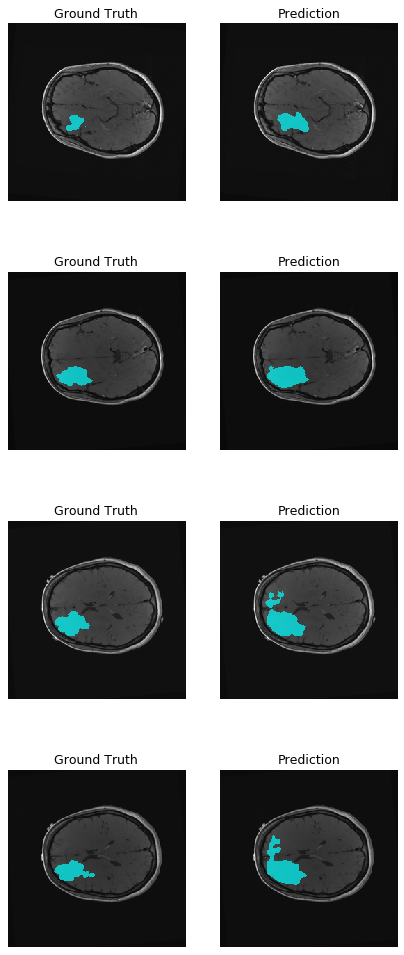

The dice score for this model is:  0.5332118007580663


In [13]:
# Cell 6

#model.load_weights("./model.h5")
preds_test = model.predict(test_X, verbose=1)
preds_test = (preds_test > 0.5).astype(np.uint8)


from skimage.measure import label

def getLargestCC(segmentation):
    labels = label(segmentation)
    unique, counts = np.unique(labels, return_counts=True)
    list_seg=list(zip(unique, counts))[1:] # the 0 label is by default background so take the rest
    if len(list_seg) > 0:
        largest=max(list_seg, key=lambda x:x[1])[0]
        labels_max=(labels == largest).astype(np.uint8)
        return labels_max
    else:
        return 0

def np_dice(true, pred):
    intersection = np.sum(true * pred)
    dc =(2.0 * intersection) / (np.sum(true) + np.sum(pred))
    return dc

fig=plt.figure(figsize=(130, 130), dpi = 75)

for j in range(0,8,2):
    i = random.randint(0,test_X.shape[0]-1)
    image = test_X[i,...,0]
    mask =  test_Y[i,...,0]
    mask = ma.masked_where(mask == 0, mask)
    pred = preds_test[i,...,0]
    pred = getLargestCC(pred)
    pred = ma.masked_where(pred == 0, pred)
    
    fig.add_subplot(8, 2, j+1)
    plt.imshow(image, cmap = "gray")
    plt.imshow(mask, 'cool', alpha=0.7)
    plt.title("Ground Truth")
    plt.axis('off')
    
    fig.add_subplot(8, 2, j+2)
    plt.imshow(image, cmap = "gray")
    plt.imshow(pred, 'cool', alpha=0.7)
    plt.title("Prediction")
    plt.axis('off')
    
plt.subplots_adjust(bottom=0.1, left = 0.01, right=0.05, top=0.3)
plt.show()

print("The dice score for this model is: ", np_dice(test_Y, preds_test))


In [14]:
# now go back through and segmented the unlabeled slices
df = pd.read_csv(DATA_FILE)
#model.load_weights("./model86.h5")

proc = 0

for ind in df.index: 
    if 'LGG' in str(df['Filename'][ind]):
        BottomOfTumor = int(df['BottomOfTumor'][ind])
        TopOfTumor = int(df['TopOfTumor'][ind])
        BottomOfTrace = int(df['BottomOfTrace'][ind])
        TopOfTrace = int(df['TopOfTrace'][ind])
        if BottomOfTrace != BottomOfTumor or TopOfTrace != TopOfTumor:
            Dir = os.path.join (IMAGE_DIR, df['Filename'][ind])
            print ("Working on " + str(Dir))
            T1_file = os.path.join (Dir, df['Filename'][ind] + '_T1.nii.gz')
            if not os.path.exists(T1_file):
                T1_file = os.path.join (Dir, df['Filename'][ind] + '_T1c.nii.gz')
            T2_file = os.path.join (Dir, df['Filename'][ind] + '_T2.nii.gz')
            Seg_file = os.path.join (Dir, df['Filename'][ind] + '-Segmentation.nii.gz')
            Chromosome_status = str(df['1p19q'][ind])
            Grade = int(df['Grade'][ind])
            Type = str(df['Type'][ind])
    #            print (T1_file + ' size: ' + str(os.path.getsize(T1_file)))
            try:
                T1, hdr = load_nifti(T1_file)
                T2, hdr = load_nifti(T2_file)
                Seg, hdr = load_nifti(Seg_file) # note saving the header for later use
        #Store the training slices into the arrays
        # note the slice number start from 1 in ITK-Snap, so must start/stop at 1 less

                nImages = []
                for slc in range (BottomOfTumor-1, TopOfTumor):
                    # combine the T1 and T2 images
                    image = np.dstack((T1[:,:, slc], T2[:,:, slc]))
                    nImages.append (image)
        #            print (str(slc))
                nImages = np.asarray(nImages)
                preds = model.predict(nImages, verbose=1)
                preds = (preds > 0.5).astype(np.uint8)

        #       msk = []
        #       for slc in range (BottomOfTumor-1, TopOfTumor):
        #           msk = np.append(preds[slc-BottomOfTumor+1,...,0])

                preds = preds[:,:,:,0]
                msk = getLargestCC(preds)
                msk = ma.masked_where(msk == 0, msk)

                for slc in range(BottomOfTumor-1, TopOfTumor):
                    Seg[:,:,slc] = msk[slc-BottomOfTumor+1,:,:]
                Seg = np.array(Seg, dtype=np.int16)
                fname = os.path.join (Dir, df['Filename'][ind] + '-Segmentation.nii.gz')
        #        print ("Saving " + fname)
                nib.save(nib.Nifti1Image(Seg, hdr.affine, hdr.header), fname)
                print ("Processed " + Dir + " which had " + str(np.sum(Seg)) + " pixels on")
                proc = proc + 1
            except:
                print ("Error on " + Dir)

print (str(proc) + " exams were updated.")

Working on /content/drive/My Drive/LGG-1p19q/Nifti/LGG-581
8/8 [==============================] - 0s 14ms/step
Processed /content/drive/My Drive/LGG-1p19q/Nifti/LGG-581 which had 1272 pixels on
Working on /content/drive/My Drive/LGG-1p19q/Nifti/LGG-582
9/9 [==============================] - 0s 2ms/step
Processed /content/drive/My Drive/LGG-1p19q/Nifti/LGG-582 which had 3784 pixels on
Working on /content/drive/My Drive/LGG-1p19q/Nifti/LGG-585
18/18 [==============================] - 0s 9ms/step
Processed /content/drive/My Drive/LGG-1p19q/Nifti/LGG-585 which had 1611 pixels on
Working on /content/drive/My Drive/LGG-1p19q/Nifti/LGG-587
17/17 [==============================] - 0s 9ms/step
Processed /content/drive/My Drive/LGG-1p19q/Nifti/LGG-587 which had 25917 pixels on
Working on /content/drive/My Drive/LGG-1p19q/Nifti/LGG-610
31/31 [==============================] - 0s 7ms/step
Processed /content/drive/My Drive/LGG-1p19q/Nifti/LGG-610 which had 99671 pixels on
Working on /content/drive/